In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly 
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [2]:
ddf = dd.read_csv('../transactions_dataset.csv', sep=';')
ddf = ddf[ddf['sales_net'] > 0]  # Exclude the often duplicate 0 sales transactions 
                                # And exclude refunds 

# Compute the result to get a pandas DataFrame
df = ddf.compute()

In [3]:
df.columns

Index(['date_order', 'date_invoice', 'product_id', 'client_id', 'sales_net',
       'quantity', 'order_channel', 'branch_id'],
      dtype='object')

In [5]:
len(df['client_id'].unique())

170586

In [6]:
len(df['branch_id'].unique())

582

In [12]:
gc.collect()

800

c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


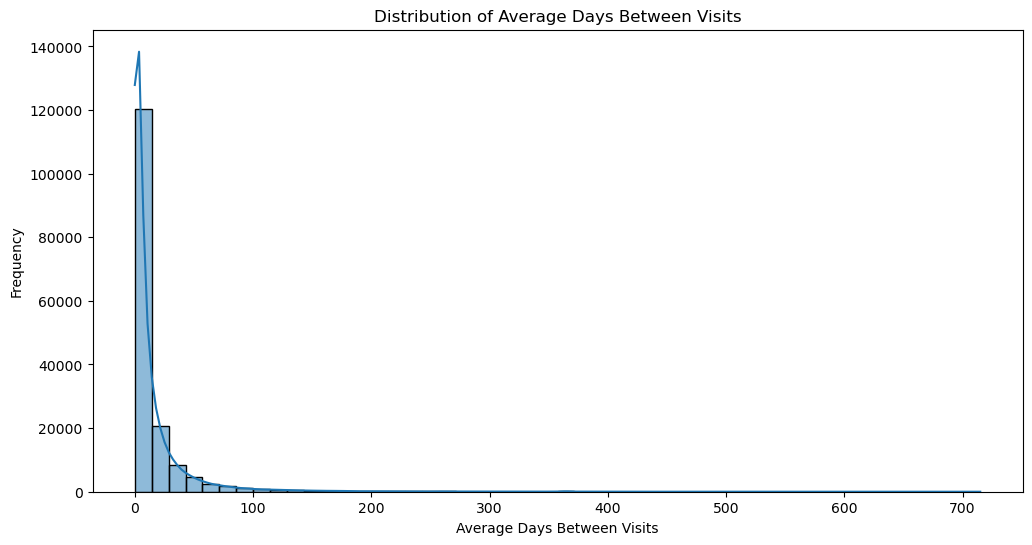

In [ ]:
# Sort data by 'client_id' and 'date_order'
df_sorted = df.sort_values(by=['client_id', 'date_order'])

df_sorted['days_between_visits'] = df_sorted.groupby('client_id')['date_order'].diff().dt.days

avg_days_between_visits = df_sorted.groupby('client_id')['days_between_visits'].mean().reset_index()

avg_days_between_visits = avg_days_between_visits.dropna()

plt.figure(figsize=(12, 6))
sns.histplot(avg_days_between_visits['days_between_visits'], bins=50, kde=True)
plt.title('Distribution of Average Days Between Visits')
plt.xlabel('Average Days Between Visits')
plt.ylabel('Frequency')
plt.show()


In [55]:
# Sort data by 'client_id' and 'date_order'
df_sorted = df.sort_values(by=['client_id', 'date_order'])

# Calculate the difference in days between consecutive orders for each client
df_sorted['days_between_visits'] = df_sorted.groupby('client_id')['date_order'].diff().dt.days

# Identify customers who have at least one visit within 30 days
customers_quick_return = df_sorted[df_sorted['days_between_visits'] < 30]['client_id'].unique()

# Identify customers who never return
# These are customers who either have no subsequent visits or all subsequent visits are beyond 30 days
customers_never_return = df_sorted.groupby('client_id').filter(lambda x: x['days_between_visits'].dropna().empty or (x['days_between_visits'].dropna() >= 30).all())['client_id'].unique()

# Total number of unique customers
total_customers = df_sorted['client_id'].nunique()

# Proportion of customers who visit again in less than 30 days
proportion_quick_return = len(customers_quick_return) / total_customers

# Proportion of customers who never return
proportion_never_return = len(customers_never_return) / total_customers

print(f"Proportion of customers who visit again in less than 30 days: {proportion_quick_return:.2%}")
print(f"Proportion of customers who never return: {proportion_never_return:.2%}")


Proportion of customers who visit again in less than 30 days: 94.54%
Proportion of customers who never return: 5.46%


In [56]:
gc.collect()

0

What does a customer who doesnt return for >30 days look like vs one who has a quick revisit period

c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


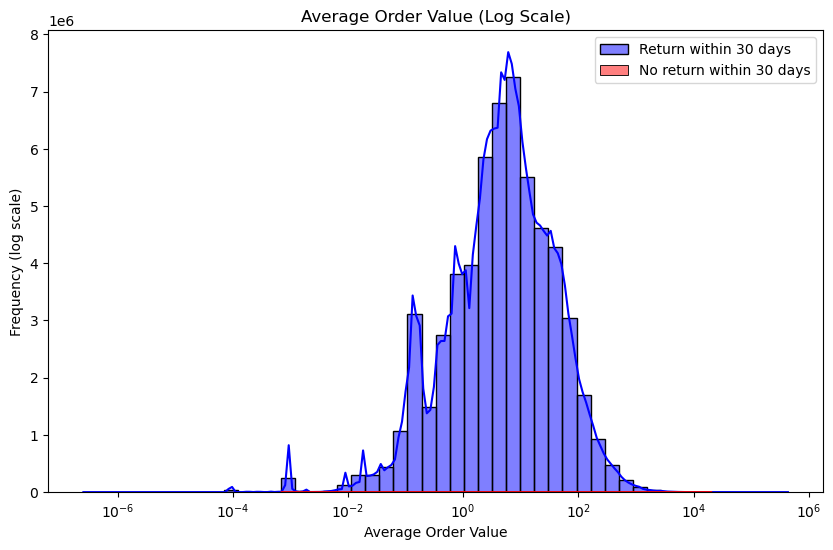

c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


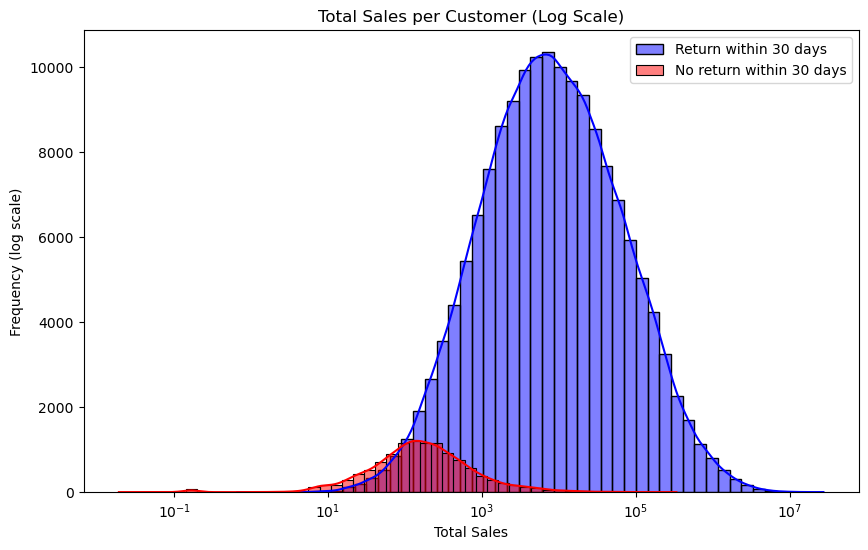

c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


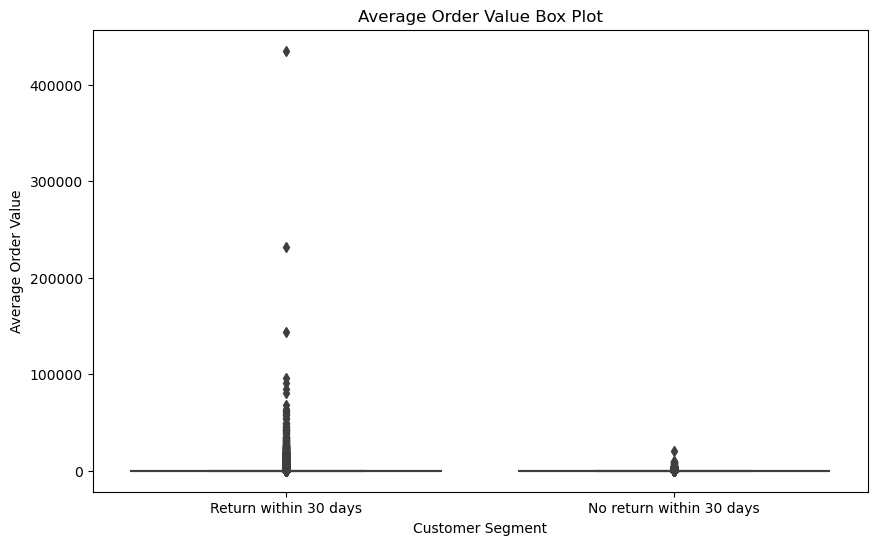

c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


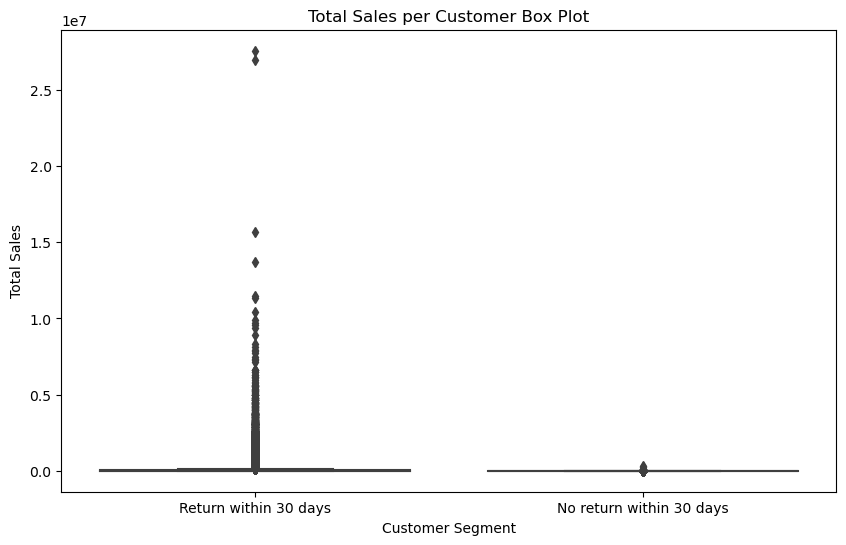

In [59]:
customers_return = df_sorted[df_sorted['client_id'].isin(customers_quick_return)]
customers_no_return = df_sorted[df_sorted['client_id'].isin(customers_never_return)]

def plot_with_log_scale(data, column, title, xlabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=50, kde=True, log_scale=True, color='blue', label='Return within 30 days')
    sns.histplot(customers_no_return[column], bins=50, kde=True, log_scale=True, color='red', label='No return within 30 days')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency (log scale)')
    plt.legend()
    plt.show()

# Plot Average Order Value with log scale
plot_with_log_scale(customers_return, 'avg_order_value', 'Average Order Value (Log Scale)', 'Average Order Value')

# Plot Total Sales per Customer with log scale
total_sales_return = customers_return.groupby('client_id')['sales_net'].sum().reset_index()
total_sales_no_return = customers_no_return.groupby('client_id')['sales_net'].sum().reset_index()

plot_with_log_scale(total_sales_return, 'sales_net', 'Total Sales per Customer (Log Scale)', 'Total Sales')

# Box plot for Average Order Value
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.concat([customers_return['avg_order_value'], customers_no_return['avg_order_value']]),
            x=['Return within 30 days']*len(customers_return) + ['No return within 30 days']*len(customers_no_return),
            y=customers_return['avg_order_value'].tolist() + customers_no_return['avg_order_value'].tolist())
plt.title('Average Order Value Box Plot')
plt.xlabel('Customer Segment')
plt.ylabel('Average Order Value')
plt.show()

# Box plot for Total Sales per Customer
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.concat([total_sales_return['sales_net'], total_sales_no_return['sales_net']]),
            x=['Return within 30 days']*len(total_sales_return) + ['No return within 30 days']*len(total_sales_no_return),
            y=total_sales_return['sales_net'].tolist() + total_sales_no_return['sales_net'].tolist())
plt.title('Total Sales per Customer Box Plot')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.show()


Consider a really basic churn case of just looking at how long from the final date a customer had last visited the store 

In [61]:
churn_threshold = 30 # days

In [62]:
current_date = df['date_order'].max()
recency = df.groupby('client_id')['date_order'].max().reset_index()
recency['recency'] = (current_date - recency['date_order']).dt.days

frequency = df.groupby('client_id').size().reset_index(name='frequency')
monetary = df.groupby('client_id')['sales_net'].sum().reset_index(name='monetary')  # total sales

rfm = recency[['client_id', 'recency']].merge(frequency, on='client_id').merge(monetary, on='client_id')

# Define churn based on recency
churn_threshold = 100 # days
rfm['churn'] = (rfm['recency'] > churn_threshold).astype(int)

In [63]:
rfm

,client_id,recency,frequency,monetary,churn
0,6,40,36,5.882233e+03,0
1,7,272,15,1.190777e+03,1
2,14,2,12157,3.154930e+06,0
3,18,10,2003,2.456277e+05,0
4,25,347,4,3.745861e+02,1
...,...,...,...,...,...
170581,2274456,20,20,1.542821e+03,0
170582,2274479,207,8,4.959214e+02,1
170583,2274504,264,4,1.132566e+02,1
170584,2274508,704,4,7.270190e+01,1


Add some more features

In [64]:
df['avg_order_value'] = df['sales_net'] / df['quantity']
avg_order_value = df.groupby('client_id')['avg_order_value'].mean().reset_index()

rfm = rfm.merge(avg_order_value, on='client_id')

# Modal preferred channel
preferred_channel = df.groupby('client_id')['order_channel'].agg(lambda x: x.mode()[0]).reset_index(name='preferred_channel')

rfm = rfm.merge(preferred_channel, on='client_id')

rfm = pd.get_dummies(rfm, columns=['preferred_channel'], drop_first=True)


In [65]:
rfm

,client_id,recency,frequency,monetary,churn,avg_order_value,preferred_channel_by phone,preferred_channel_during the visit of a sales rep,preferred_channel_online,preferred_channel_other
0,6,40,36,5.882233e+03,0,17.433272,True,False,False,False
1,7,272,15,1.190777e+03,1,14.209886,False,False,False,False
2,14,2,12157,3.154930e+06,0,38.766462,True,False,False,False
3,18,10,2003,2.456277e+05,0,26.452097,False,False,False,False
4,25,347,4,3.745861e+02,1,13.923924,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
170581,2274456,20,20,1.542821e+03,0,12.153149,False,False,False,False
170582,2274479,207,8,4.959214e+02,1,15.976375,False,False,False,False
170583,2274504,264,4,1.132566e+02,1,8.612350,False,False,False,False
170584,2274508,704,4,7.270190e+01,1,2.176674,False,False,False,False


See how well we can predict a customer not coming back from these features

In [66]:
X = rfm.drop(columns=['recency', 'client_id', 'churn'])
y = rfm['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [67]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))


[[17414  3777]
 [ 5313  7614]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     21191
           1       0.67      0.59      0.63     12927

    accuracy                           0.73     34118
   macro avg       0.72      0.71      0.71     34118
weighted avg       0.73      0.73      0.73     34118

AUC-ROC: 0.7902479026337156


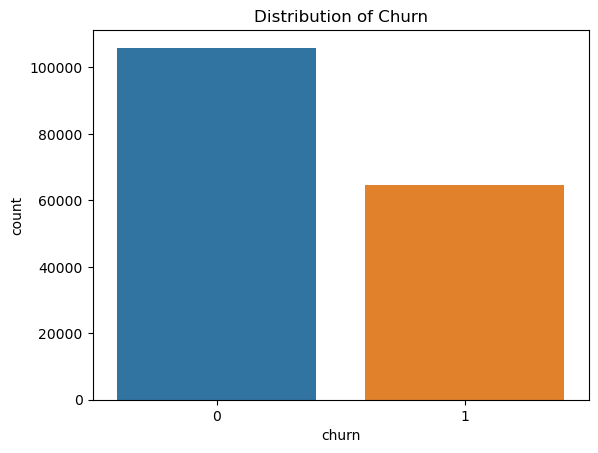

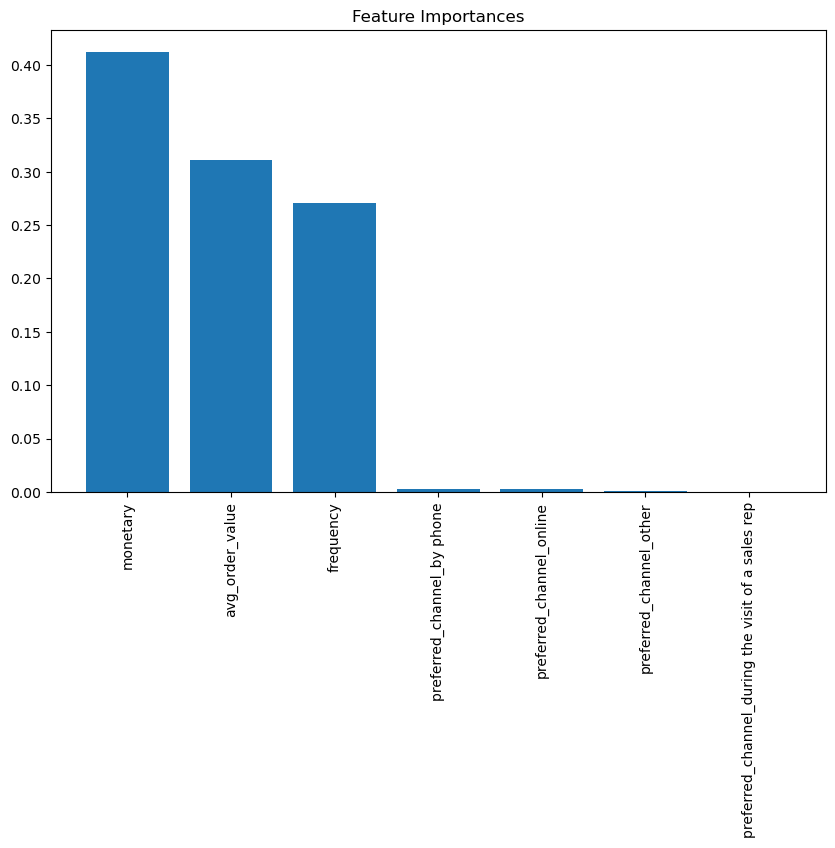

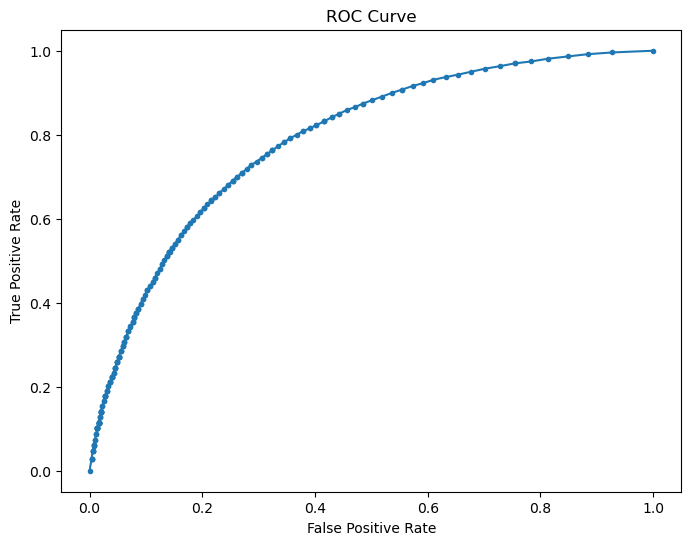

In [68]:
sns.countplot(x='churn', data=rfm)
plt.title('Distribution of Churn')
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [69]:
gc.collect()

12609

### A better churn model where we dont just take them from the end but rather when someone has lapsed for more than 30 days at any point

In [71]:
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,avg_order_value,days_between_visits,lapsed
124594,2017-10-27,2017-10-27,2173586,6,55.821000,5,by phone,8470,11.164200,NaN,False
141749,2017-10-27,2017-10-27,857055,6,21.046886,401,by phone,8470,0.052486,0.0,False
160656,2017-10-27,2017-10-27,2299248,6,20.470000,5,by phone,8470,4.094000,0.0,False
168097,2017-10-27,2017-10-27,482165,6,8.418000,61,by phone,8470,0.138000,0.0,False
172163,2017-10-27,2017-10-27,1437249,6,48.467072,101,by phone,8470,0.479872,0.0,False


In [72]:
df.shape

(58514567, 11)

In [ ]:
df['date_order'] = pd.to_datetime(df['date_order'])

df['days_between_visits'] = df.groupby('client_id')['date_order'].diff().dt.days

df['lapsed'] = df['days_between_visits'] > 30
churn_labels = df.groupby('client_id')['lapsed'].any().reset_index(name='churn')

print("Churn Labels:\n", churn_labels.head())

rfm = pd.DataFrame({
'client_id': df['client_id'].unique(),
'recency': np.random.randint(0, 365, size=df['client_id'].nunique()),
'frequency': np.random.randint(1, 100, size=df['client_id'].nunique()),
'monetary': np.random.rand(df['client_id'].nunique()) * 1000
})

print("RFM before merge:\n", rfm.head())

rfm = rfm.merge(churn_labels, on='client_id', how='left')

print("RFM after merge with churn labels:\n", rfm.head())

df['avg_order_value'] = df['sales_net'] / df['quantity']
avg_order_value = df.groupby('client_id')['avg_order_value'].mean().reset_index()
rfm = rfm.merge(avg_order_value, on='client_id', how='left')

preferred_channel = df.groupby('client_id')['order_channel'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index(name='preferred_channel')
rfm = rfm.merge(preferred_channel, on='client_id', how='left')

print("RFM after merging preferred channel:\n", rfm.head())
rfm = pd.get_dummies(rfm, columns=['preferred_channel'], drop_first=True)

print("RFM after one-hot encoding:\n", rfm.head())


X = rfm.drop(columns=['client_id', 'churn'])
y = rfm['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Churn Labels:
    client_id  churn
0          6   True
1          7   True
2         14  False
3         18  False
4         25  False
RFM before merge:
    client_id  recency  frequency    monetary
0          6      186          6  520.439683
1          7      178          5  258.710031
2         14      210         43  668.193750
3         18      330         49  143.010752
4         25      265         96  138.414465
RFM after merge with churn labels:
    client_id  recency  frequency    monetary  churn
0          6      186          6  520.439683   True
1          7      178          5  258.710031   True
2         14      210         43  668.193750  False
3         18      330         49  143.010752  False
4         25      265         96  138.414465  False
RFM after merging preferred channel:
    client_id  recency  frequency    monetary  churn  avg_order_value  \
0          6      186          6  520.439683   True        17.433272   
1          7      178          5  258.710031  

This model is pretty poor